## Probe tip detection

Notebook for testing and comparing methods of detecting neuropixels probe tips in camera.

We'll start with a standard template matching approach, then move to ML approaches if needed.

In [1]:
import json
import numpy as np

# contains many images of probe tip
data_path = 'test_data/trainingData20230202/'

# contains a dict {filename: {'pt1': (x, y), 'pt2': (x, y)}
# where pt1 is the probe tip and pt2 is the base.
#   (generated manually using parallax/tools/annotate_training_data.py)
meta_file = data_path + 'meta.json'
meta = json.load(open(meta_file, 'r'))

### Show one example

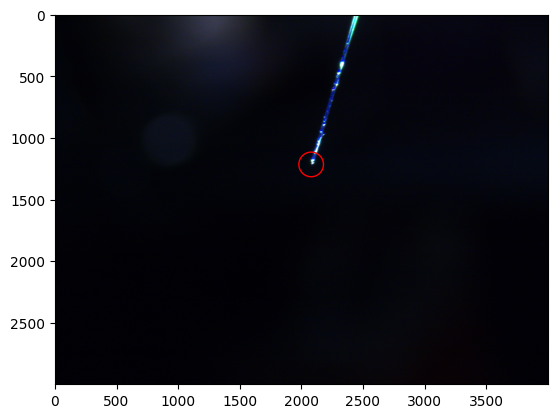

In [2]:
import matplotlib.pyplot as plt

img_file = list(meta.keys())[0]

def load_image(filename):
    return plt.imread(filename)

img = load_image(img_file)

def show_image(img, pt, ax=None):
    if ax is None:
        fig,ax = plt.subplots()
    circle = plt.Circle(pt, 100, edgecolor='red', fill=False)
    ax.add_artist(circle)
    ax.imshow(img)

p1 = meta[img_file]['pt1']
p2 = meta[img_file]['pt2']
show_image(img, p1)

### Get a template

1215 2080


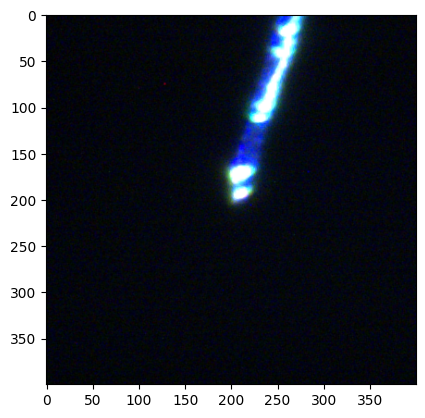

In [3]:
template_radius = 200
j = int(p1[0])
i = int(p1[1])
print(i, j)
template = img[i-template_radius:i+template_radius, j-template_radius:j+template_radius]
plt.imshow(template)

### Use openCV to do template matching

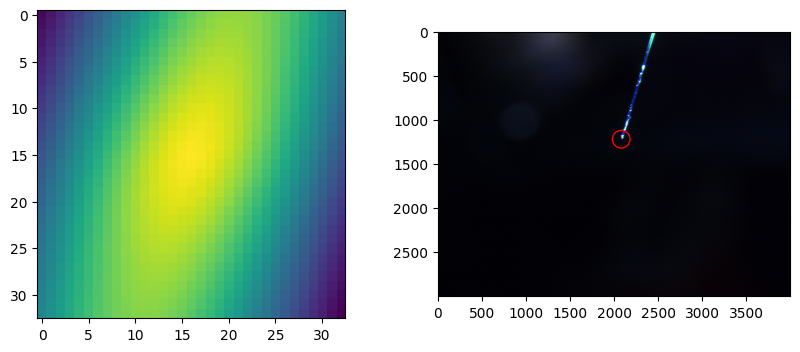

In [4]:
import cv2 as cv

# method = cv.TM_CCOEFF
# method = cv.TM_CCOEFF_NORMED
# method = cv.TM_CCORR
method = cv.TM_CCORR_NORMED
# method = cv.TM_SQDIFF
# method = cv.TM_SQDIFF_NORMED

def template_match(img, template):
    res = cv.matchTemplate(img, template, method)
    if method == cv.TM_SQDIFF_NORMED:
        ext = res.argmin()
    else:
        ext = res.argmax()
    mx = np.array(np.unravel_index(ext, res.shape))
    return res, mx



def fast_template_match(img, template, method, downsample=8):
    """2-stage template match for better performance
    """
    # should we look for min or max in match results
    ext_method = 'argmax'
    if method in (cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED):
        ext_method = 'argmin'

    # first convert to greyscale
    img = img.mean(axis=2)
    template = template.mean(axis=2)

    # do a quick template match on downsampled images
    img2 = img[::downsample, ::downsample]
    template2 = template[::downsample, ::downsample]

    res = cv.matchTemplate(img2, template2, method)
    ext = getattr(res, ext_method)()
    mx = np.array(np.unravel_index(ext, res.shape)) * downsample

    crop = [
        (max(0, mx[0] - downsample*2), mx[0] + template.shape[0] + downsample*2),
        (max(0, mx[1] - downsample*2), mx[1] + template.shape[1] + downsample*2),
    ]

    img3 = img[crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
    res = cv.matchTemplate(img3, template, method)
    ext = getattr(res, ext_method)()
    mx = np.array(np.unravel_index(ext, res.shape))

    return res, mx + [crop[0][0], crop[1][0]]



res, mx = fast_template_match(img, template, method)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(res)
circle = plt.Circle(mx[::-1], 100, edgecolor='red', fill=False)
ax[0].add_artist(circle)

ax[1].imshow(img)
circle2 = plt.Circle(mx[::-1]+template_radius, 100, edgecolor='red', fill=False)
ax[1].add_artist(circle2)


### Test on all images

In [5]:
from tqdm.notebook import tqdm

images = {}
for fn in tqdm(meta):
    images[fn] = load_image(fn)

  0%|          | 0/56 [00:00<?, ?it/s]

In [7]:
results = {}
for fn,img in tqdm(images.items()):
    res, mx = fast_template_match(img, template, method)
    results[fn] = mx[::-1]

  0%|          | 0/56 [00:00<?, ?it/s]

Text(0.5, 0, '2D error (pixels)')

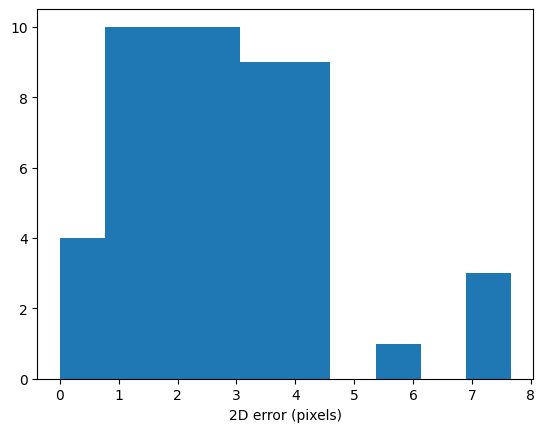

In [8]:
distances = {}
for fn, pred_pt in results.items():
    dist = np.linalg.norm(pred_pt + template_radius - meta[fn]['pt1'])
    distances[fn] = dist
    

fig,ax = plt.subplots()
ax.hist(distances.values())
ax.set_xlabel('2D error (pixels)')

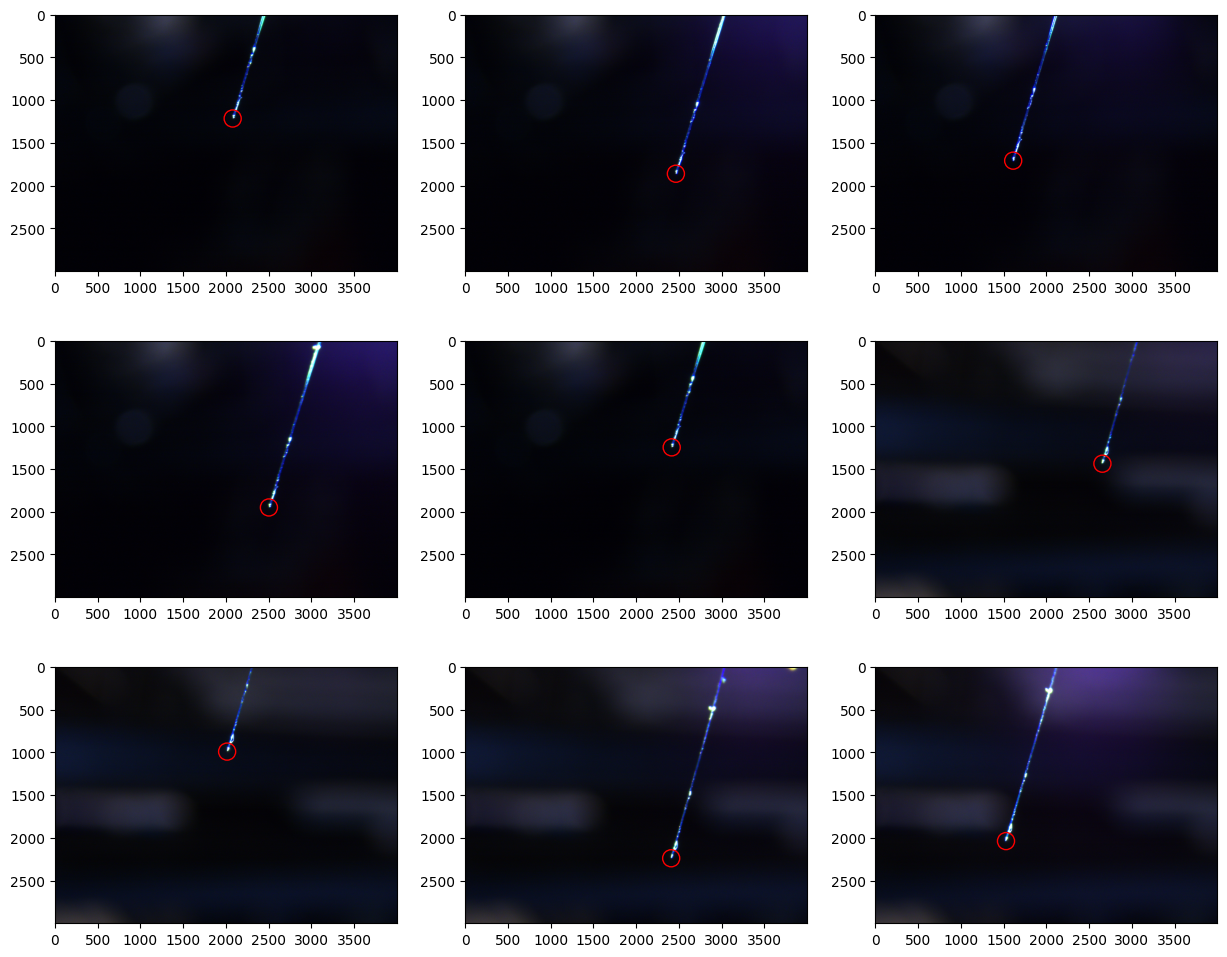

In [9]:
fig, ax = plt.subplots(3, 3, figsize=(15, 12))
keys = list(meta.keys())
skip = len(keys) // 9
for i in range(3):
    for j in range(3):
        n = i * 3 + j
        key = keys[n*skip]
        show_image(images[key], results[key] + template_radius, ax[i, j])